In [1]:
import raw_data
import ta

import math

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
daily_adjusted_df = raw_data.get_time_series_daily_adjusted("msft")
prediction_period = 1  # predict 1 day into the future

display.display(daily_adjusted_df.describe())
display.display(daily_adjusted_df.head(5))

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5.960000e+03,5960.000000,5960.000000
mean,55.470969,56.162841,54.785379,55.494916,26.638197,4.237067e+07,0.002562,1.000671
std,34.166645,34.658273,33.658528,34.197385,18.961481,3.046236e+07,0.046281,0.025900
min,15.200000,15.620000,14.870000,15.150000,2.423500,7.111000e+05,0.000000,1.000000
25%,27.417500,27.710000,27.210000,27.457500,17.478850,2.185800e+07,0.000000,1.000000
50%,43.980000,44.500000,43.555000,43.990000,21.428700,3.814835e+07,0.000000,1.000000
75%,77.597500,79.025000,76.690000,77.690000,28.917300,5.712868e+07,0.000000,1.000000
max,178.940000,180.380000,175.750000,179.940000,112.330000,5.910522e+08,3.080000,2.000000


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2018-08-31,111.685,112.777,111.515,112.33,112.33,23216875,0.0,1.0
1,2018-08-30,111.670,112.610,111.440,111.95,111.95,22798702,0.0,1.0
2,2018-08-29,110.450,112.030,110.270,112.02,112.02,20818044,0.0,1.0
3,2018-08-28,109.940,110.500,109.790,110.26,110.26,19151528,0.0,1.0
4,2018-08-27,109.270,109.640,108.510,109.60,109.60,19662331,0.0,1.0


In [3]:
def preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period, means=None, stds=None):
    selected_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]

    # Truncate the most recent prediction_period days
    processed_df = selected_features.iloc[prediction_period:].copy()
    
    # Add technical indicators
    ta.add_all_ta_features(processed_df, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    processed_df = processed_df.drop("volatility_kchi", axis=1)

    if means is None:
        means = processed_df.mean().copy()
    if stds is None:
        stds = processed_df.std().copy()

    # Normalize features
    processed_df = (processed_df - means) / stds
    
    # Add the target column
    if prediction_period == 0:
        processed_df["future_change"] = 0
    else:
        start_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[prediction_period:].values
        end_adjusted_closes = daily_adjusted_df["adjusted_close"].iloc[:-prediction_period].values
        processed_df["future_change"] = (end_adjusted_closes - start_adjusted_closes) / start_adjusted_closes
        
    return processed_df, means, stds

In [4]:
def preprocess_features(df):
    processed_features = df.iloc[:, df.columns != "future_change"].copy()
    return processed_features

def preprocess_targets(df):
    processed_targets = df["future_change"].copy()
    return processed_targets

In [5]:
df, means, stds = preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period)
display.display(df.describe())
display.display(df.head(5))

df = df.sample(frac=1)  # Shuffle df

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_change
count,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,...,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5959.000000
mean,5.608983e-15,6.562892e-15,7.593113e-15,5.876078e-15,1.907817e-17,6.105016e-16,-1.430863e-17,-4.769543e-18,1.526254e-15,1.788579e-17,...,-2.442006e-15,2.480163e-16,-2.060443e-15,4.960325e-16,-3.205133e-15,7.631270e-17,-8.346701e-18,8.346701e-18,-4.273511e-15,0.000837
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.019849
min,-1.178556e+00,-1.169678e+00,-1.185792e+00,-1.278374e+00,-1.367611e+00,-7.778027e+00,-1.139119e+01,-4.325398e+00,-5.309731e+00,-3.670229e+01,...,-6.162033e+00,-6.026775e+00,-7.143713e+00,-6.911664e+00,-7.143713e+00,-3.177697e+00,-8.227952e+00,-8.986132e+00,-1.278374e+00,-0.156067
25%,-8.209924e-01,-8.207946e-01,-8.191125e-01,-4.831143e-01,-6.734850e-01,-4.603877e-01,-7.219137e-01,-4.813141e-01,-5.577705e-01,-4.760178e-02,...,-7.184231e-01,-1.949910e-01,-4.704856e-01,-4.758647e-01,-4.704856e-01,-2.275620e-01,-4.778304e-01,-4.708719e-01,-4.831143e-01,-0.008677
50%,-3.363860e-01,-3.365711e-01,-3.335735e-01,-2.744463e-01,-1.385863e-01,1.917199e-01,-3.820392e-02,-1.127155e-02,1.845463e-01,1.344013e-02,...,-2.169004e-02,-8.574325e-02,2.394569e-01,2.368061e-01,2.394569e-01,-3.157417e-02,7.647895e-03,1.757357e-02,-2.744463e-01,0.000292
75%,6.474629e-01,6.588573e-01,6.501331e-01,1.210258e-01,4.843691e-01,7.688946e-01,7.341295e-01,4.373455e-01,7.544168e-01,6.516727e-02,...,7.526565e-01,-1.908928e-02,7.384451e-01,7.396618e-01,7.384451e-01,1.693027e-01,4.634749e-01,4.719211e-01,1.210258e-01,0.010024
max,3.614524e+00,3.584831e+00,3.594716e+00,4.511027e+00,1.801077e+01,1.257206e+00,6.159403e+00,7.336595e+00,1.364429e+00,1.831073e+01,...,7.478065e+00,7.803166e+00,1.308217e+00,1.295186e+00,1.308217e+00,1.246479e+01,9.342215e+00,8.592048e+00,4.511027e+00,0.195751


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_change
1,1.645363,1.629180,1.683760,4.507329,-0.642570,1.241166,0.003426,0.010619,1.364429,0.013702,...,0.457942,7.803166,1.195655,1.209596,1.195655,0.018982,0.022336,0.032278,4.507329,0.003394
2,1.609650,1.612443,1.648994,4.511027,-0.707586,1.250611,0.404767,0.010619,1.364429,0.013702,...,7.478065,7.803166,1.195655,1.209596,1.195655,0.018982,0.053848,0.063811,4.511027,-0.000625
3,1.594721,1.568291,1.634731,4.418055,-0.762291,1.255493,-0.365787,0.010619,1.364429,0.198756,...,-5.162992,7.803166,1.195655,1.209596,1.195655,0.018982,-0.769478,-0.766593,4.418055,0.015962
4,1.575109,1.543474,1.596696,4.383191,-0.745523,1.254256,-0.375635,0.010619,1.364429,0.097671,...,-5.649100,7.803166,1.195655,1.209596,1.195655,0.018982,-0.279334,-0.270590,4.383191,0.006022
5,1.528273,1.512308,1.568467,4.319801,-0.825234,1.257206,-0.328820,0.010619,1.364429,0.120781,...,-5.890663,7.803166,1.195655,1.209596,1.195655,0.018982,-0.529458,-0.523094,4.319801,0.011070


In [6]:
num_rows = len(df)
# Use 90% for training and rest for validation
num_training = int(num_rows * 0.9)
num_validation = num_rows - num_training

training_examples = preprocess_features(df.head(num_training))
training_targets = preprocess_targets(df.head(num_training))

validation_examples = preprocess_features(df.tail(num_validation))
validation_targets = preprocess_targets(df.tail(num_validation))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,...,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000
mean,0.000536,0.000485,0.000536,0.001539,0.004244,-0.006433,0.002588,-0.000520,-0.000014,-0.003181,...,0.001007,-0.002431,0.000738,-0.001560,-0.001217,-0.001560,0.002661,-0.001959,-0.001963,0.001539
std,1.000591,1.000580,1.000818,1.005834,1.009794,1.008231,1.005372,0.999559,0.997931,0.837867,...,0.997363,0.999111,1.006538,0.998814,1.000450,0.998814,0.994859,0.999167,1.000454,1.005834
min,-1.178556,-1.169678,-1.185792,-1.278374,-1.367611,-7.778027,-11.391186,-4.325398,-5.309731,-24.138532,...,-3.151159,-6.162033,-6.026775,-7.143713,-6.911664,-7.143713,-3.161390,-8.227952,-8.986132,-1.278374
25%,-0.821724,-0.822093,-0.819410,-0.483973,-0.671757,-0.475826,-0.723047,-0.479359,-0.562974,-0.048968,...,-0.697791,-0.713366,-0.195303,-0.471754,-0.474986,-0.471754,-0.224866,-0.483152,-0.476252,-0.483973
50%,-0.331117,-0.329645,-0.329711,-0.275334,-0.135798,0.190079,-0.039025,-0.011140,0.181613,0.013414,...,0.017369,-0.020214,-0.085692,0.237428,0.235750,0.237428,-0.030833,0.006827,0.016751,-0.275334
75%,0.661514,0.667803,0.660385,0.116419,0.486220,0.768585,0.738024,0.434476,0.752930,0.064760,...,0.700272,0.743677,-0.019546,0.737751,0.739078,0.737751,0.171331,0.463342,0.471789,0.116419
max,3.614524,3.584831,3.594716,4.511027,18.010770,1.257206,6.159403,7.336595,1.364429,17.492331,...,3.383742,7.478065,7.803166,1.306342,1.295186,1.306342,12.464792,8.552107,7.920151,4.511027


Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,...,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,-0.004822,-0.004363,-0.004827,-0.013849,-0.038186,0.057882,-0.023289,0.004676,0.000130,0.028624,...,-0.009065,0.021873,-0.006638,0.014036,0.010947,0.014036,-0.023943,0.017628,0.017660,-0.013849
std,0.995491,0.995595,0.993436,0.946579,0.907013,0.921408,0.950787,1.004789,1.019281,1.919916,...,1.024230,1.008546,0.939894,1.011344,0.996708,1.011344,1.045685,1.008141,0.996570,0.946579
min,-1.136696,-1.124084,-1.139437,-1.278094,-1.337533,-5.282849,-2.597749,-3.553746,-4.654405,-36.702286,...,-2.591361,-2.521434,-2.677997,-6.671506,-6.752360,-6.671506,-3.177697,-2.932594,-3.015760,-1.278094
25%,-0.811625,-0.813934,-0.811201,-0.462297,-0.684260,-0.358053,-0.706699,-0.503715,-0.523834,-0.035084,...,-0.762408,-0.787743,-0.191058,-0.459280,-0.489823,-0.459280,-0.233918,-0.442028,-0.434689,-0.462297
50%,-0.362878,-0.364707,-0.354671,-0.266303,-0.174686,0.197162,0.003426,-0.012696,0.217893,0.013696,...,0.012538,-0.028780,-0.086238,0.260931,0.263741,0.260931,-0.042234,0.022336,0.032278,-0.266303
75%,0.522103,0.519838,0.545091,0.175612,0.442661,0.775088,0.708242,0.488349,0.763003,0.069928,...,0.683536,0.857583,-0.012244,0.745647,0.749023,0.745647,0.140520,0.475913,0.484262,0.175612
max,3.204709,3.191508,3.119280,4.175474,3.738288,1.231745,3.015824,4.513866,1.355555,18.310734,...,2.553522,2.400549,7.803166,1.308217,1.281279,1.308217,9.378049,9.342215,8.592048,4.175474


Training targets summary:


count    5363.000000
mean        0.000877
std         0.019882
min        -0.144752
25%        -0.008675
50%         0.000311
75%         0.010132
max         0.195751
Name: future_change, dtype: float64

Validation targets summary:


count    596.000000
mean       0.000483
std        0.019561
min       -0.156067
25%       -0.008920
50%        0.000000
75%        0.009300
max        0.062285
Name: future_change, dtype: float64

In [7]:
display.display(validation_examples.head(5))
display.display(validation_targets.head(5))

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
3397,-0.886709,-0.876200,-0.880028,-0.408098,1.248478,-0.995774,1.553562,2.958259,-0.395713,0.075767,...,1.622199,0.212530,0.089309,0.250666,0.211354,0.250666,0.134153,0.161122,0.171007,-0.408098
4679,1.300532,1.299631,1.262108,0.307756,-0.346196,-0.025779,0.617011,-0.219351,-0.165571,-0.027712,...,1.056410,1.322246,-0.127711,-0.142822,-0.147974,-0.142822,0.246636,0.278806,0.288344,0.307756
2086,-0.814113,-0.817043,-0.824164,-0.246840,1.497419,-0.351440,1.699764,1.220778,0.780826,0.305268,...,1.121378,0.911678,0.288342,0.820806,0.741794,0.820806,0.195562,0.529267,0.537163,-0.246840
4620,0.677906,0.684396,0.675242,-0.036117,-0.531126,-1.876903,0.508402,-0.567346,-0.226355,-5.043717,...,-0.209855,0.381197,0.027916,0.290886,-0.169104,0.290886,0.437821,9.342215,8.592048,-0.036117
5354,1.929306,1.929006,1.963971,-0.873188,-1.272351,0.826885,-0.066229,-0.018460,-1.484989,0.035290,...,-0.450257,-0.305691,-0.081003,-1.637555,-1.429891,-1.637555,-0.472712,-1.470394,-1.484467,-0.873188


3397   -0.002746
4679   -0.005063
2086   -0.009959
4620   -0.156067
5354    0.030523
Name: future_change, dtype: float64

In [8]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [9]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=optimizer)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.4f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.4f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.4f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 0.0115
  period 01 : 0.0083
  period 02 : 0.0069
  period 03 : 0.0060
  period 04 : 0.0060
  period 05 : 0.0051
  period 06 : 0.0047
  period 07 : 0.0046
  period 08 : 0.0043
  period 09 : 0.0040
Model training finished.
Final RMSE (on training data):   0.0040
Final RMSE (on validation data): 0.0045


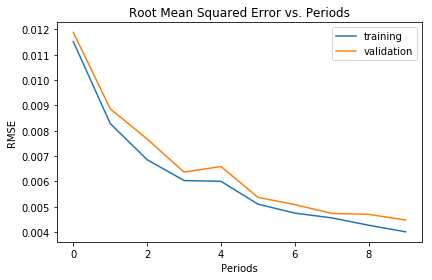

In [15]:
regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.1),
    steps=2000,
    batch_size=30,
    hidden_units=[30, 30, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

(59, 30)
Darker corresponds to more negative, lighter corresponds to more positive.


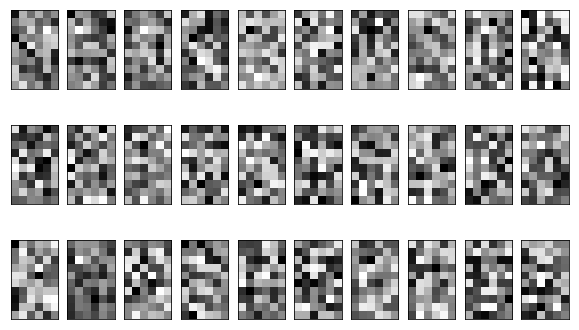

In [16]:
weights0 = regressor.get_variable_value("dnn/hiddenlayer_0/kernel")
print(weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(10, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    padded = np.pad(coef, (0, 1), "constant")
    cax = ax.matshow(np.expand_dims(padded, 0).reshape(10, 6), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())

print("Darker corresponds to more negative, lighter corresponds to more positive.")
plt.show()

In [17]:
recent_df, _, _ = preprocess_daily_adjusted_df(daily_adjusted_df.head(prediction_period + 365), 0, means, stds)
recent_features = preprocess_features(recent_df).head(prediction_period)
recent_targets = preprocess_targets(recent_df).head(prediction_period)
predict_recent_input_fn = lambda: input_fn(recent_features, recent_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_recent_input_fn)
predictions = [item["predictions"][0] for item in predictions]
display.display(predictions)

[-0.0078027053]